In [1]:
#!pip install alpha_vantage
import numpy as np

In [2]:
from alpha_vantage.timeseries import TimeSeries
# Your key here
key = 'DXE06U7BMVFM3AGC'
ts = TimeSeries(key)
aapl, meta = ts.get_daily(symbol='AAPL')
print(aapl['2019-09-12'])

{'1. open': '224.8000', '2. high': '226.4200', '3. low': '222.8600', '4. close': '223.0900', '5. volume': '32226700'}


In [3]:
import json
symbol = 'AMZN'
data = ts.get_intraday(symbol,interval = '60min',outputsize='full')
data = data[0]
#data

In [4]:
sdata = {k:float(v['1. open']) for k,v in data.items()}
sdata = sorted(sdata.items())
#sdata

In [5]:
import matplotlib.pyplot as pp
values = [t[1] for t in sdata]
pp.plot(values)
pp.show()

<Figure size 640x480 with 1 Axes>

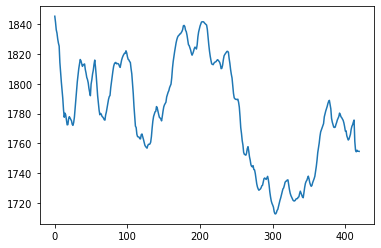

In [17]:
def smooth(values,beta=0.95):
    smoothed_vals = []
    prev = values[0]
    for v in values:
        moving_val = beta*prev + (1-beta)*v
        smoothed_vals.append(moving_val)
        prev = smoothed_vals[-1]
    return smoothed_vals

smoothed = smooth(values,0.8)
pp.plot(smoothed)

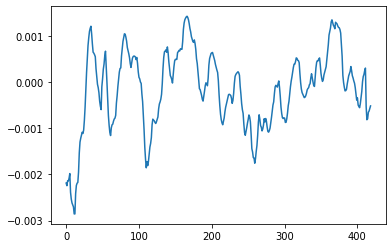

In [18]:
import math
def gradient(values):
    grads = []
    for i in range(len(values)-1):
        grad = (-values[i]+values[i+1])/values[i]
        grads.append(grad)
    return grads
grads = gradient(smoothed)
pp.plot(smooth(grads,0.9))

In [19]:
mins = [i for i in range(len(grads)-1) if grads[i]<0 and grads[i+1]>0]
maxs = [i for i in range(len(grads)-1) if grads[i]>0 and grads[i+1]<0]

print(mins,maxs)



[12, 16, 24, 37, 48, 61, 68, 84, 89, 96, 117, 126, 129, 146, 188, 194, 217, 228, 250, 262, 271, 280, 290, 303, 329, 341, 352, 384, 399, 403, 414] [13, 19, 34, 40, 54, 62, 83, 85, 95, 97, 119, 128, 139, 177, 192, 203, 223, 236, 251, 265, 272, 288, 292, 320, 337, 348, 377, 391, 400, 411, 415]


In [20]:
def plot_together(values,mins,maxs):
    values = np.array(values)
    pp.plot(values)
    pp.scatter(mins,values[mins],c='green')
    pp.scatter(maxs,values[maxs],c='red')
    pp.show()

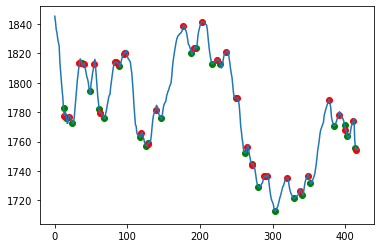

In [21]:
plot_together(smoothed,mins,maxs)

In [22]:
def truncate(values,mins,maxs,factor= 3):
    values = np.array(values)
    global_max = np.max(values)
    global_min = np.min(values)
    #print(global_max,global_min)
    diff = global_max - global_min
    #print(diff)
    
    new_mins=[]
    new_maxs=[]
    for n,x in zip(mins,maxs):
        if values[x]-values[n]>diff/factor:
            new_mins.append(n)
            new_maxs.append(x)
        else:
            if len(new_maxs)>0 and values[x]>values[new_maxs[-1]]:
                new_maxs[-1] = x
    return new_mins,new_maxs
            

In [28]:
new_mins,new_maxs = truncate(smoothed,mins,maxs,5)

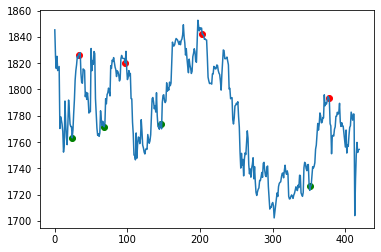

In [29]:
plot_together(values,new_mins,new_maxs)

In [30]:
def correct_min_max(values,mins,maxs):
    mins.append(len(values)-1)
    mins.insert(0,0)
    values = np.array(values)
    
    correct_mins=[]
    correct_maxs=[]
    for i in range(len(mins)-1):
        curr = mins[i]
        next = mins[i+1]
        subarray = values[curr:next]
        max_index = np.argmax(subarray)+mins[i]
        correct_maxs.append(max_index)
        
    maxs.append(len(values)-1)
    maxs.insert(0,0)
    for i in range(len(maxs)-1):
        curr = maxs[i]
        next = maxs[i+1]
        subarray = values[curr:next]
        min_index = np.argmin(subarray)+maxs[i]
        correct_mins.append(min_index)
    return correct_mins,correct_maxs
    
    

In [31]:
correct_mins,correct_maxs = correct_min_max(values,new_mins.copy(),new_maxs.copy())

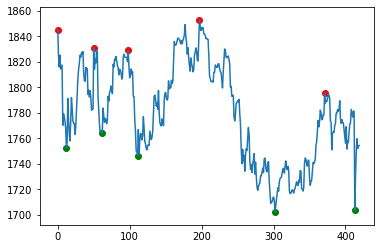

In [32]:
plot_together(values,correct_mins,correct_maxs)